In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from tensorflow import keras

from keras import layers
from keras import losses

from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator


data = pd.read_csv('/content/Final_eskom_vector_grid_health.csv')
data = pd.DataFrame(data)
data['Time'] = pd.to_datetime(data['DateTime'])
data.set_index('Time', inplace=True)


Y_columns = [
    'ILS Usage',
    'MLR', 'IOS Excl ILS and MLR',
     'Total UCLF+OCLF'
]
Y = data[Y_columns].values
X = data.drop(columns=Y_columns, axis=1)
X.drop(['DateTime'], axis =1, inplace = True)
X = X.values

X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(X, Y, test_size=0.10, shuffle=False, random_state=42)

# Then, split the temporary test set into validation (50%) and final test (50%)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_temp, Y_train_temp, test_size=0.10, shuffle=False, random_state=42)

# Print the shapes of the resulting sets
print("Training set (X_train, Y_train) shapes:", X_train.shape, Y_train.shape)
print("Validation set (X_val, Y_val) shapes:", X_val.shape, Y_val.shape)
print("Test set (X_test, Y_test) shapes:", X_test.shape, Y_test.shape)


scaler = StandardScaler()
X_train_normalised = scaler.fit_transform(X_train)
X_test_normalised = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

Y_train_normalised = scaler.fit_transform(Y_train)
Y_test_normalised = scaler.transform(Y_test)
Y_val_norm = scaler.transform(Y_val)


timesteps = 24*7
window_length = timesteps
batch_size = 16
num_features = 15
train_generator = TimeseriesGenerator(X_train_normalised, Y_train_normalised,length=window_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test_normalised, Y_test_normalised,length=window_length, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val_norm, Y_val_norm, length=window_length, batch_size=batch_size)


Training set (X_train, Y_train) shapes: (27254, 15) (27254, 4)
Validation set (X_val, Y_val) shapes: (3029, 15) (3029, 4)
Test set (X_test, Y_test) shapes: (3365, 15) (3365, 4)


## Final test on architecture type 2Layers-1B-1L vs 3Layers-2B-1L vs 2Layers-2L

In [24]:
epochs = 50
num_layers = 16
patience = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)

In [ ]:
## 2 layers 2 LSTM
 #num epochs without improvement

model_simple = tf.keras.Sequential([
  layers.LSTM(16, input_shape = (window_length, 15), return_sequences=True, activation='tanh'),
  layers.Dropout(0.2),
  layers.LSTM(16, input_shape = (window_length, 15)),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model_simple.build((None, timesteps, 15))
model_simple.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model_simple.compile(loss=tf.keras.losses.Huber(delta = 0.3),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber()])
history_simple = model_simple.fit(train_generator, epochs=epochs, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 16)           2048      
                                                                 
 dropout (Dropout)           (None, 168, 16)           0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 4228 (16.52 KB)
Trainable params: 4228 (16.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
1118/1118 [

In [ ]:
## 2 layers 1 Birectional 1 LSTM

modelH03 = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(16, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.LSTM(16,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

modelH03.build((None, timesteps, 15))
modelH03.summary()

modelH03.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber()])

history_2Layers_simple = modelH03.fit(train_generator, epochs=epochs, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 168, 32)           4096      
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 168, 32)           0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 7300 (28.52 KB)
Trainable params: 7300 (28.52 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [ ]:
## 3 layers 2 Bidirectional 1 LSTM
model_decay_3 = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(16, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.Bidirectional(layers.LSTM(16,  return_sequences=True)),
  layers.Dropout(0.2),
  layers.LSTM(16,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model_decay_3.build((None, timesteps, 15))
model_decay_3.summary()

model_decay_3.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber()])
model_history_decay_3 = model_decay_3.fit(train_generator, epochs=epochs, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 168, 32)           4096      
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 168, 32)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 168, 32)           6272      
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 168, 32)           0         
                                                                 
 lstm_6 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_6 (Dropout)         (None, 16)               

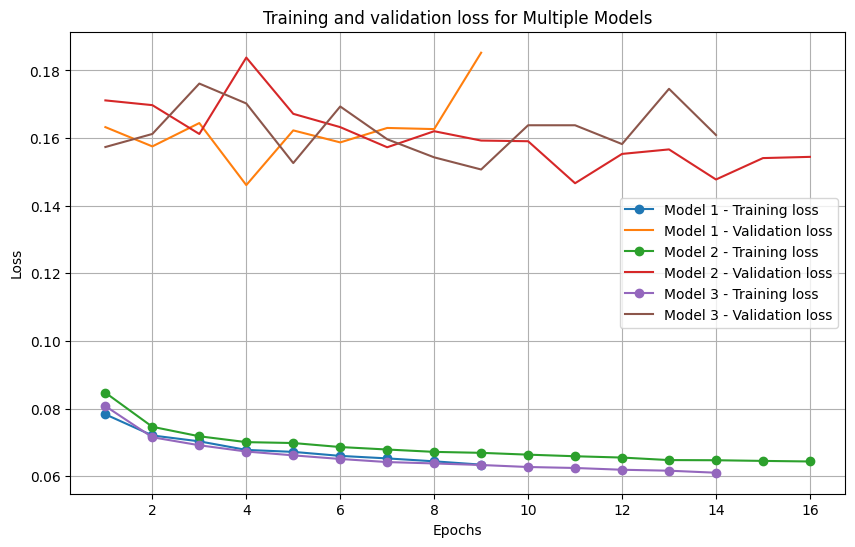

In [12]:
history_dicts = [history_simple.history, history_2Layers_simple.history, model_history_decay_3.history]

# Define labels for each model
model_labels = ['Model 1', 'Model 2', 'Model 3']

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop through each model's history
for i, history_dict in enumerate(history_dicts):
    error = history_dict['huber_loss']
    val_error = history_dict['val_huber_loss']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(error) + 1)

    # Plot training loss with dots
    plt.plot(epochs, loss, 'o-', label=f'{model_labels[i]} - Training loss')

    # Plot validation loss with lines
    plt.plot(epochs, val_loss, '-', label=f'{model_labels[i]} - Validation loss')

plt.title('Training and validation loss for Multiple Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# Test 2 (add parameter decay and 0.4 dropout)



In [11]:
## 2 layers 2 LSTM
 #num epochs without improvement

model_simple = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(8, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.Bidirectional(layers.LSTM(8,  return_sequences=True)),
  layers.Dropout(0.2),
  layers.LSTM(8,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model_simple.build((None, timesteps, 15))
model_simple.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=True, restore_best_weights=True)


model_simple.compile(loss=tf.keras.losses.Huber(delta = 0.3),
                optimizer=tf.keras.optimizers.Adam(weight_decay= 1e-3, learning_rate = 0.005),
                metrics=[tf.keras.losses.Huber(delta = 0.3)])
history_simple = model_simple.fit(train_generator, epochs=epochs, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirect  (None, 168, 16)           1536      
 ional)                                                          
                                                                 
 dropout_18 (Dropout)        (None, 168, 16)           0         
                                                                 
 bidirectional_13 (Bidirect  (None, 168, 16)           1600      
 ional)                                                          
                                                                 
 dropout_19 (Dropout)        (None, 168, 16)           0         
                                                                 
 lstm_20 (LSTM)              (None, 8)                 800       
                                                                 
 dropout_20 (Dropout)        (None, 8)                

In [6]:
## 2 layers 1 Birectional 1 LSTM

modelH03 = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(8, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.4),
  layers.Bidirectional(layers.LSTM(8,  return_sequences=True)),
  layers.Dropout(0.4),
  layers.LSTM(8,  return_sequences=False),
  layers.Dropout(0.4),
  layers.Dense(4, activation='linear')])

modelH03.build((None, timesteps, 15))
modelH03.summary()

modelH03.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(weight_decay= 1e-3),
                metrics=[tf.keras.losses.Huber(delta = 0.3)])

history_2Layers_simple = modelH03.fit(train_generator, epochs=epochs, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 168, 16)           1536      
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 168, 16)           0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 168, 16)           1600      
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 168, 16)           0         
                                                                 
 lstm_11 (LSTM)              (None, 8)                 800       
                                                                 
 dropout_11 (Dropout)        (None, 8)                

In [25]:
## 3 layers 2 Bidirectional 1 LSTM ## BEST MODEL
model_decay_3 = tf.keras.Sequential([
  layers.Bidirectional(
  layers.LSTM(8, input_shape = (window_length, 15), return_sequences=True, activation='tanh')),
  layers.Dropout(0.2),
  layers.Bidirectional(layers.LSTM(8,  return_sequences=True)),
  layers.Dropout(0.2),
  layers.LSTM(8,  return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(4, activation='linear')])

model_decay_3.build((None, timesteps, 15))
model_decay_3.summary()

model_decay_3.compile(loss=tf.keras.losses.Huber(delta=0.3),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.losses.Huber(delta = 0.3),'mean_absolute_error'])
model_history_decay_3 = model_decay_3.fit(train_generator, epochs=epochs, validation_data= val_generator,  callbacks=[early_stopping], verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_18 (Bidirect  (None, 168, 16)           1536      
 ional)                                                          
                                                                 
 dropout_27 (Dropout)        (None, 168, 16)           0         
                                                                 
 bidirectional_19 (Bidirect  (None, 168, 16)           1600      
 ional)                                                          
                                                                 
 dropout_28 (Dropout)        (None, 168, 16)           0         
                                                                 
 lstm_29 (LSTM)              (None, 8)                 800       
                                                                 
 dropout_29 (Dropout)        (None, 8)                

Through multiple testing found, 2 Bidirectional layers with an added LSTM layer is the best performing, has the lowest validation loss for test 4 and test 5 of 0.0976 and 0.0958 respectively

In [27]:
predictions = model_decay_3.evaluate(test_generator, batch_size=16)
predictions


200/200 [==============================] - 3s 17ms/step - loss: 0.3420 - huber_loss: 0.3423 - mean_absolute_error: 1.2273


[0.34198155999183655, 0.34233757853507996, 1.2272858619689941]

In [32]:
model_decay_3.save("/final_model.keras")